In [1]:
# Import of relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn import preprocessing
import sklearn.metrics as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import tree
import pickle

from sklearn.linear_model import LogisticRegression

RSEED = 42

# Preprocessing

## Functions

In [2]:
def dropCols(df):
    drop_cols = [
        'blurb',
        'creator',
        'currency',
        'currency_trailing_code',
        'fx_rate',
        'location',
        'name',
        'profile',
        'slug',
        'source_url',
        'static_usd_rate',
        'usd_type',
        "country",
        "is_starrable",
        'converted_pledged_amount',
        'pledged',
        'category_slug',
        'disable_communication',
        'usd_pledged',
        #"backers_count",
        #"staff_pick",
    ]
    df.drop(drop_cols, inplace=True, axis = 1)
    for c in df.columns: 
        if df[c].dtype == "object": 
            df[c] = df[c].astype("category") 
    df.dropna(inplace=True)
    return df

def toDay(time_delta):
    return round(time_delta/3600/24,2)

def dateTimeUpdate(df):
    campaign_length = df.deadline - df.created_at
    campaign_length = campaign_length.apply(toDay)
    campaign_length.name = "campaign_length"
    
    time_until_launch = df.launched_at - df.created_at
    time_until_launch = time_until_launch.apply(toDay)
    time_until_launch.name = "time_until_launch"
    
    time_launch2state = df.state_changed_at - df.launched_at
    time_launch2state = time_launch2state.apply(toDay)
    time_launch2state.name = "time_launch2state"
    
    time_state2deadline = df.deadline - df.state_changed_at
    time_state2deadline = time_state2deadline.apply(toDay)
    time_state2deadline.name = "time_state2deadline"
    
    time_launch2deadline = df.deadline - df.launched_at
    time_launch2deadline = time_launch2deadline.apply(toDay)
    time_launch2deadline.name = "time_launch2deadline"
    
    df = pd.concat([df, 
                    campaign_length,
                    time_until_launch, 
                    #time_launch2state,
                    #time_state2deadline,
                    #time_launch2deadline
                   ],
                  axis = 1
                  )
    df.drop([
        "created_at",
        "deadline",
        "launched_at",
        "state_changed_at",
            ],
        axis =1,
        inplace=True
    )
    return df


## Load data, drop unnecessary columns

In [3]:
df = pd.read_csv('data/df_clean.csv')
df = dropCols(df)
df = dateTimeUpdate(df)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.head()
#df.goal = np.log10(df.goal)
df

,backers_count,goal,staff_pick,state,category_name,cgrouped,campaign_length,time_until_launch
0,2,5000.0,False,failed,Woodworking,Other,24.36,1.36
1,1561,30000.0,False,successful,Video Games,US,304.63,274.58
2,306,100000.0,True,successful,Wearables,US,76.31,40.52
3,192,6500.0,True,successful,Indie Rock,US,74.59,41.10
4,0,20000.0,False,canceled,Farms,US,757.56,727.56
...,...,...,...,...,...,...,...,...
163613,137,2500.0,False,successful,Hardware,GB,45.32,15.32
163614,2,20000.0,False,failed,Nature,US,31.05,0.06
163615,17,6000.0,False,failed,Gadgets,US,106.39,73.41
163616,1,1000.0,False,failed,Radio & Podcasts,US,32.57,2.57


In [4]:
#df.describe()

In [5]:
#sns.scatterplot(data = df, x= "time_state2deadline",y="goal" )
#plt.xscale("log")

## Define categorical and numerical columns

In [6]:
cat_features = list(df.columns[df.dtypes=='category'])
cat_features.remove('state')
cat_features

['category_name', 'cgrouped']

In [7]:
num_features = list(df.columns[df.dtypes!='category'])
num_features

['backers_count', 'goal', 'staff_pick', 'campaign_length', 'time_until_launch']

## Define training data

Targets will only be "failed" and "successful" because, only these are purely market driven classes and therefore can be best related to the features. To predict for example "cancelled" more insights into the founders' business would be necessary.

In [8]:
X = df[(df['state']=='failed') | (df['state']=='successful')].drop("state", axis=1)
y = df[(df['state']=='failed') | (df['state']=='successful')]["state"]
print(f"fearture Rows: {X.shape[0]} \nfeature columns: {X.shape[1]}")
print(f"target rows: {y.shape[0]}")

fearture Rows: 151867 
feature columns: 7
target rows: 151867


In [9]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(["failed","successful"])
print("before: \n{}".format(np.array(y[:10])))
y = label_encoder.transform(y)
print("-----"*10)
print("after: \n{}".format(y[:10]))

before: 
['failed' 'successful' 'successful' 'successful' 'successful' 'successful'
 'successful' 'successful' 'successful' 'failed']
--------------------------------------------------
after: 
[0 1 1 1 1 1 1 1 1 0]


## Split the training data

In [10]:
X

,backers_count,goal,staff_pick,category_name,cgrouped,campaign_length,time_until_launch
0,2,5000.0,False,Woodworking,Other,24.36,1.36
1,1561,30000.0,False,Video Games,US,304.63,274.58
2,306,100000.0,True,Wearables,US,76.31,40.52
3,192,6500.0,True,Indie Rock,US,74.59,41.10
5,552,33000.0,True,Print,US,32.86,1.86
...,...,...,...,...,...,...,...
163613,137,2500.0,False,Hardware,GB,45.32,15.32
163614,2,20000.0,False,Nature,US,31.05,0.06
163615,17,6000.0,False,Gadgets,US,106.39,73.41
163616,1,1000.0,False,Radio & Podcasts,US,32.57,2.57


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=RSEED)
X_train, X_train_alt, y_train, y_train_alt = train_test_split(X_train, y_train, train_size=0.1,stratify=y_train, random_state=RSEED)

In [12]:
X_train

,backers_count,goal,staff_pick,category_name,cgrouped,campaign_length,time_until_launch
149091,117,10000.0,False,Tabletop Games,US,375.76,345.76
66548,42,850.0,False,Playing Cards,US,30.01,0.02
14015,0,450.0,False,Painting,Europe,30.53,0.53
97463,35,7000.0,False,Webseries,US,75.63,50.63
86772,9,2000.0,False,Interactive Design,US,73.58,58.10
...,...,...,...,...,...,...,...
111743,6,750000.0,False,Mixed Media,GB,161.14,131.14
121800,7,3500.0,False,DIY,US,45.23,10.23
60952,4,30000.0,False,Apps,Europe,458.53,428.53
99647,202,15000.0,True,Graphic Novels,US,35.65,5.65


## Setup the preprocessing pipeline

In [13]:
# Pipeline for numerical features 
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])
# Pipeline for categorical features
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
# Complete pipeline for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

#preprocess validationData
preprocessor.fit(X_train)
X_test = preprocessor.transform(X_test)
#X_train = preprocessor.transform(X_train)
#extract feature names
cat_cols= preprocessor.transformers_[1][1].named_steps["1hot"].get_feature_names(cat_features)
features = list(num_features) + list(cat_cols)

# Logistic Regression

In [90]:
# LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression())
])

#Grid search Parameters
param_logreg = {"logreg__penalty":['l2'],
                "logreg__dual":[False],
                "logreg__tol":[0.01, 0.1, 1, 10],
                "logreg__C":[0.1, 1.0, 10, 100],
                "logreg__fit_intercept":[True],
                "logreg__intercept_scaling":[1],
                "logreg__class_weight":[None],
                "logreg__random_state":[RSEED],
                "logreg__solver":['lbfgs'],
                "logreg__max_iter":[100,1000,10000],
                "logreg__multi_class":['auto'],
                "logreg__verbose":[0],
                "logreg__warm_start":[False],
                "logreg__n_jobs":[None],
                "logreg__l1_ratio":[None],
               }

grid_logreg = GridSearchCV(pipe_logreg,
                           param_grid=param_logreg,
                           cv=5, 
                           scoring='accuracy',
                           verbose=5, 
                           n_jobs=-1)

In [91]:
grid_logreg.fit(X_train, y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [92]:
grid_logreg.best_params_

{'logreg__C': 100,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 1000,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': 42,
 'logreg__solver': 'lbfgs',
 'logreg__tol': 0.01,
 'logreg__verbose': 0,
 'logreg__warm_start': False}

In [93]:
logreg_model = grid_logreg.best_estimator_['logreg']
y_log_pred_test = logreg_model.predict(X_test)
print(sm.classification_report(y_test, y_log_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89     13348
           1       0.94      0.88      0.91     17026

    accuracy                           0.90     30374
   macro avg       0.90      0.90      0.90     30374
weighted avg       0.90      0.90      0.90     30374



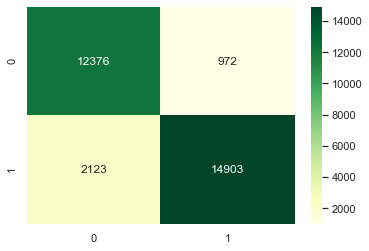

In [94]:
# Print confusion matrix
sns.heatmap(confusion_matrix(y_test, y_log_pred_test), annot=True, cmap='YlGn', fmt='d');

In [20]:
filename = './models/LogRegModel.sav'
pickle.dump(logreg_model, open(filename, 'wb'))

# KNN

In [21]:
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

#Grid search Parameters
param_knn = {
            "knn__n_neighbors":[5,20,50],
            "knn__weights":['uniform',"distance"],
            "knn__algorithm":['auto'],
            "knn__leaf_size":[30],
            "knn__p":[2,1,100],
            "knn__metric":['minkowski'],
            "knn__metric_params":[None],
            "knn__n_jobs":[None],
               }

grid_knn = GridSearchCV(pipe_knn,
                           param_grid=param_knn,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [22]:
grid_knn.fit(X_train, y_train);

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/Users/pmcrae/Documents/neueFische/project-kickstarter/.venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.85465538 0.84570317 0.8628938  0.85529221        nan        nan
 0.87470701 0.87118347 0.88679423 0.87875739        nan        nan
 0.87368625 0.87546603 0.88009274 0.8863161         nan        nan]
  warnings.warn(


In [23]:
grid_knn.best_params_

{'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 20,
 'knn__p': 1,
 'knn__weights': 'uniform'}

In [24]:
knn_model = grid_knn.best_estimator_['knn']
y_knn_pred_test = knn_model.predict(X_test)
print(sm.classification_report(y_test, y_knn_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81     13348
           1       0.88      0.78      0.83     17026

    accuracy                           0.82     30374
   macro avg       0.82      0.82      0.82     30374
weighted avg       0.83      0.82      0.82     30374



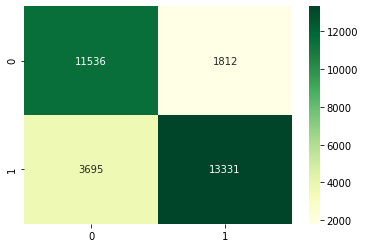

In [25]:
sns.heatmap(confusion_matrix(y_test, y_knn_pred_test), annot=True, cmap='YlGn', fmt='d');

In [26]:
filename = './models/KNNModel.sav'
pickle.dump(knn_model, open(filename, 'wb'))

# Naive Bayes

In [27]:
pipe_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('nb', BernoulliNB())
])

#Grid search Parameters
param_nb = {'nb__alpha': [1,3,10,30],
            "nb__binarize" : [0.0],
            "nb__fit_prior":[True],
            "nb__class_prior":[None]
            }


grid_nb = GridSearchCV(pipe_nb,
                           param_grid=param_nb,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [28]:
grid_nb.fit(X_train, y_train);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [29]:
grid_nb.best_params_

{'nb__alpha': 3,
 'nb__binarize': 0.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [30]:
nb_model = grid_nb.best_estimator_['nb']
y_nb_pred_test = nb_model.predict(X_test)
print(sm.classification_report(y_test, y_nb_pred_test))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79     13348
           1       0.87      0.76      0.81     17026

    accuracy                           0.80     30374
   macro avg       0.81      0.81      0.80     30374
weighted avg       0.81      0.80      0.81     30374



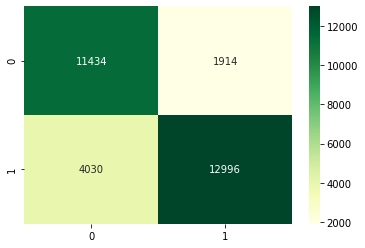

In [31]:
sns.heatmap(confusion_matrix(y_test, y_nb_pred_test), annot=True, cmap='YlGn', fmt='d');

In [32]:
filename = './models/NaiveBayesModel.sav'
pickle.dump(nb_model, open(filename, 'wb'))

# Decision Tree

In [33]:
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeClassifier())
])

#Grid search Parameters
param_dt = {"dt__criterion":['gini',"entropy"],
            "dt__splitter":['best'],
            "dt__max_depth":[None,5,8,10,15,20],
            "dt__min_samples_split":[10,50,100],
            "dt__min_samples_leaf":[2],
            "dt__min_weight_fraction_leaf":[0.0],
            "dt__max_features":[None],
            "dt__random_state":[RSEED],
            "dt__max_leaf_nodes":[None],
            "dt__min_impurity_decrease":[0.0],
            "dt__min_impurity_split":[None],
            "dt__class_weight":[None],
            "dt__ccp_alpha":[0.0],
            }

grid_dt = GridSearchCV(pipe_dt,
                           param_grid=param_dt,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [34]:
grid_dt.fit(X_train,y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [35]:
grid_dt.best_params_

{'dt__ccp_alpha': 0.0,
 'dt__class_weight': None,
 'dt__criterion': 'entropy',
 'dt__max_depth': 5,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_impurity_split': None,
 'dt__min_samples_leaf': 2,
 'dt__min_samples_split': 50,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__random_state': 42,
 'dt__splitter': 'best'}

In [36]:
dt_model = grid_dt.best_estimator_["dt"]
y_dt_pred_test = dt_model.predict(X_test)
print(sm.classification_report(y_test, y_dt_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     13348
           1       0.92      0.94      0.93     17026

    accuracy                           0.92     30374
   macro avg       0.92      0.92      0.92     30374
weighted avg       0.92      0.92      0.92     30374



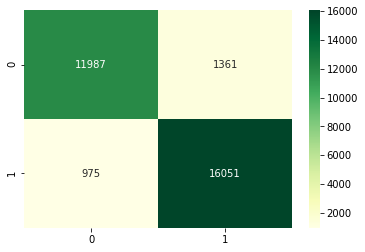

In [37]:
sns.heatmap(confusion_matrix(y_test, y_dt_pred_test), annot=True, cmap='YlGn', fmt='d');

In [38]:
fi = pd.DataFrame({'feature': features,
                   'importance': dt_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(10)

,feature,importance
0,backers_count,0.793245
1,goal,0.196475
162,cgrouped_Asia,0.003391
4,time_until_launch,0.001773
155,category_name_Webcomics,0.001704
3,campaign_length,0.001594
129,category_name_Rock,0.000926
7,category_name_Accessories,0.000891
108,category_name_Photobooks,0.000000
109,category_name_Photography,0.000000


In [39]:
from graphviz import render
from graphviz import Source

tree.export_graphviz(dt_model,
                     out_file="tree3.dot",
                     feature_names = features, 
                     class_names=["failed", "sucessful"],
                     filled = True)
# Convert a .dot file to .png

render("dot", "png", "tree3.dot")
# To render an existing file in a notebook

#Source.from_file("tree3.dot")

'tree3.dot.png'

In [40]:
filename = './models/DecisionTreeModel.sav'
pickle.dump(dt_model, open(filename, 'wb'))

# SVC

In [41]:
pipe_svc = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

#Grid search Parameters
param_svc = {
            "svc__C":[1.0, 0.1, 10.0, 100.0],
            "svc__kernel":['rbf'],
            "svc__degree":[3],
            "svc__gamma":['scale',"auto"],
            "svc__coef0":[0.0],
            "svc__shrinking":[True],
            "svc__probability":[False],
            "svc__tol":[0.01,1e-4,1e-3,0.1],
            "svc__cache_size":[200],
            "svc__class_weight":[None],
            "svc__verbose":[False],
            "svc__max_iter":[-1],
            "svc__decision_function_shape":['ovr'],
            "svc__break_ties":[False],
            "svc__random_state":[RSEED],
            }

grid_svc = GridSearchCV(pipe_svc,
                           param_grid=param_svc,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [42]:
grid_svc.fit(X_train,y_train);

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [43]:
grid_svc.best_params_

{'svc__C': 100.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': 42,
 'svc__shrinking': True,
 'svc__tol': 0.0001,
 'svc__verbose': False}

In [44]:
svc_model = grid_svc.best_estimator_["svc"]
y_svc_pred_test = svc_model.predict(X_test)
print(sm.classification_report(y_test,y_svc_pred_test))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86     13348
           1       0.92      0.83      0.87     17026

    accuracy                           0.87     30374
   macro avg       0.86      0.87      0.87     30374
weighted avg       0.87      0.87      0.87     30374



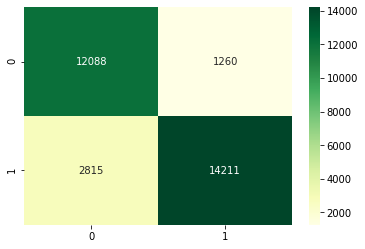

In [45]:
sns.heatmap(confusion_matrix(y_test, y_svc_pred_test), annot=True, cmap='YlGn', fmt='d');

In [46]:
filename = './models/SVCModel.sav'
pickle.dump(svc_model, open(filename, 'wb'))

# Random Forest

In [47]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier())
])

#Grid search Parameters
param_rf = {
            "rf__n_estimators":[100, 500, 1000],
            "rf__criterion":['gini',"entropy"],
            "rf__max_depth":[None,1,2,5],
            "rf__min_samples_split":[2,10,50],
            "rf__min_samples_leaf":[1],
            "rf__min_weight_fraction_leaf":[0.0],
            "rf__max_features":['auto',"sqrt"],
            "rf__max_leaf_nodes":[None],
            "rf__min_impurity_decrease":[0.0],
            "rf__min_impurity_split":[None],
            "rf__bootstrap":[True],
            "rf__oob_score":[False],
            "rf__n_jobs":[None],
            "rf__random_state":[RSEED],
            "rf__verbose":[0],
            "rf__warm_start":[False],
            "rf__class_weight":[None],
            "rf__ccp_alpha":[0.0],
            "rf__max_samples":[None],
            }

grid_rf = GridSearchCV(pipe_rf,
                           param_grid=param_rf,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [48]:
grid_rf.fit(X_train,y_train);

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [49]:
grid_rf.best_params_

{'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'entropy',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 42,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [50]:
rf_model = grid_rf.best_estimator_["rf"]
y_rf_pred_test = rf_model.predict(X_test)
print(sm.classification_report(y_test,y_rf_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93     13348
           1       0.93      0.96      0.94     17026

    accuracy                           0.94     30374
   macro avg       0.94      0.93      0.93     30374
weighted avg       0.94      0.94      0.94     30374



In [51]:
fi = pd.DataFrame({'feature': features,
                   'importance': rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(10)

,feature,importance
0,backers_count,0.477128
1,goal,0.112660
4,time_until_launch,0.063974
3,campaign_length,0.057215
2,staff_pick,0.033770
129,category_name_Rock,0.007780
59,category_name_Fiction,0.007252
167,cgrouped_US,0.006777
133,category_name_Shorts,0.006587
35,category_name_Country & Folk,0.006323


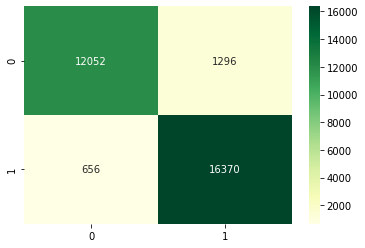

In [52]:
sns.heatmap(confusion_matrix(y_test, y_rf_pred_test), annot=True, cmap='YlGn', fmt='d');

In [53]:
filename = './models/RandomForestModel.sav'
pickle.dump(rf_model, open(filename, 'wb'))

# AdaBoost

In [54]:
pipe_ab = Pipeline([
    ('preprocessor', preprocessor),
    ('ab', AdaBoostClassifier())
])

#Grid search Parameters
param_ab = {            
            "ab__base_estimator":[None, LogisticRegression(),BernoulliNB()],
            "ab__n_estimators":[20,50,100],
            "ab__learning_rate":[0.1,1.0,10],
            "ab__algorithm":['SAMME.R'],
            "ab__random_state":[RSEED],
            }

grid_ab = GridSearchCV(pipe_ab,
                           param_grid=param_ab,
                           cv=5, 
                           scoring='precision',
                           verbose=5, 
                           n_jobs=-1)

In [55]:
grid_ab.fit(X_train,y_train);

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [56]:
grid_ab.best_params_

{'ab__algorithm': 'SAMME.R',
 'ab__base_estimator': BernoulliNB(),
 'ab__learning_rate': 0.1,
 'ab__n_estimators': 50,
 'ab__random_state': 42}

In [57]:
ab_model = grid_ab.best_estimator_["ab"]
y_ab_pred_test = ab_model.predict(X_test)
print(sm.classification_report(y_test,y_ab_pred_test))

              precision    recall  f1-score   support

           0       0.46      1.00      0.63     13348
           1       0.98      0.09      0.17     17026

    accuracy                           0.49     30374
   macro avg       0.72      0.55      0.40     30374
weighted avg       0.75      0.49      0.37     30374



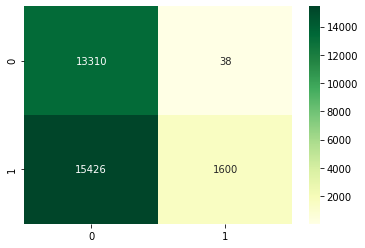

In [58]:
sns.heatmap(confusion_matrix(y_test, y_ab_pred_test), annot=True, cmap='YlGn', fmt='d');

In [59]:
filename = './models/AdaBoostModel.sav'
pickle.dump(ab_model, open(filename, 'wb'))

## Bagging SVC

In [60]:
from sklearn.ensemble import BaggingClassifier

pipe_bg = Pipeline([
    ('preprocessor', preprocessor),
    ('bg', BaggingClassifier())
])

maxfeatures = np.sqrt(X_train.shape[0]) / X_train.shape[0]

param_bg = {            
            "bg__base_estimator":[DecisionTreeClassifier()],
            "bg__n_estimators":[100],
            "bg__max_samples":[0.7], #1.0
            "bg__max_features":[maxfeatures], #1.0
            "bg__bootstrap":[True],
            "bg__bootstrap_features":[False],
            "bg__oob_score":[False],
            "bg__warm_start":[False],
            "bg__n_jobs":[None],
            "bg__random_state":[RSEED],
            "bg__verbose":[0],
            }

grid_bg = GridSearchCV(pipe_bg,
                           param_grid=param_bg,
                           cv=5, 
                           scoring='accuracy',
                           verbose=5, 
                           n_jobs=-1)

In [61]:
grid_bg.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['backers_count',
                                                                          'goal',
                                                                          'staff_pick',
                                                                          'campaign_length',
                                              

In [62]:
bg_model = grid_bg.best_estimator_["bg"]
y_bg_pred_test = bg_model.predict(X_test)
print(sm.classification_report(y_test,y_bg_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     13348
           1       0.56      1.00      0.72     17026

    accuracy                           0.56     30374
   macro avg       0.28      0.50      0.36     30374
weighted avg       0.31      0.56      0.40     30374



/Users/pmcrae/Documents/neueFische/project-kickstarter/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pmcrae/Documents/neueFische/project-kickstarter/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pmcrae/Documents/neueFische/project-kickstarter/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

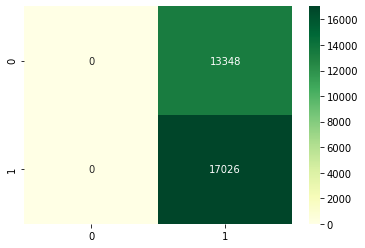

In [63]:
sns.heatmap(confusion_matrix(y_test, y_bg_pred_test), annot=True, cmap='YlGn', fmt='d');

In [64]:
filename = './models/BaggingSVCModel.sav'
pickle.dump(bg_model, open(filename, 'wb'))

## Get data for ROC Curves

In [65]:
X_train_preprocessed = preprocessor.transform(X_train)

#Logistic Regression
y_logreg_train_probs = logreg_model.predict_proba(X_train_preprocessed)[:, 1]
y_logreg_test_probs = logreg_model.predict_proba(X_test)[:, 1]
y_logreg_pred_train = logreg_model.predict(X_train_preprocessed)
y_logreg_pred_test = logreg_model.predict(X_test)

#KNN
y_knn_train_probs = knn_model.predict_proba(X_train_preprocessed)[:, 1]
y_knn_test_probs = knn_model.predict_proba(X_test)[:, 1]
y_knn_pred_train = knn_model.predict(X_train_preprocessed)
y_knn_pred_test = knn_model.predict(X_test)

#Naive Bayes
y_nb_train_probs = nb_model.predict_proba(X_train_preprocessed)[:, 1]
y_nb_test_probs = nb_model.predict_proba(X_test)[:, 1]
y_nb_pred_train = nb_model.predict(X_train_preprocessed)
y_nb_pred_test = nb_model.predict(X_test)

#Decision Tree
y_dt_train_probs = dt_model.predict_proba(X_train_preprocessed)[:, 1]
y_dt_test_probs = dt_model.predict_proba(X_test)[:, 1]
y_dt_pred_train = dt_model.predict(X_train_preprocessed)
y_dt_pred_test = dt_model.predict(X_test)

#SVC
#y_svc_train_probs = svc_model.predict_proba(X_train_preprocessed)[:, 1]
#y_svc_test_probs = svc_model.predict_proba(X_test)[:, 1]
y_svc_pred_train = svc_model.predict(X_train_preprocessed)
y_svc_pred_test = svc_model.predict(X_test)

#Random Forest
y_rf_train_probs = rf_model.predict_proba(X_train_preprocessed)[:, 1]
y_rf_test_probs = rf_model.predict_proba(X_test)[:, 1]
y_rf_pred_train = rf_model.predict(X_train_preprocessed)
y_rf_pred_test = rf_model.predict(X_test)

#Ada Boost
y_ab_train_probs = ab_model.predict_proba(X_train_preprocessed)[:, 1]
y_ab_test_probs = ab_model.predict_proba(X_test)[:, 1]
y_ab_pred_train = ab_model.predict(X_train_preprocessed)
y_ab_pred_test = ab_model.predict(X_test)

ROC curves to be done later

In [66]:
df_ev = pd.DataFrame(np.array([
    [
        sm.accuracy_score(y_test,y_logreg_pred_test),
        sm.accuracy_score(y_test,y_knn_pred_test),
        sm.accuracy_score(y_test,y_nb_pred_test),
        sm.accuracy_score(y_test,y_dt_pred_test),
        sm.accuracy_score(y_test,y_svc_pred_test),
        sm.accuracy_score(y_test,y_rf_pred_test),
        sm.accuracy_score(y_test,y_ab_pred_test),
    ],
    [
        sm.precision_score(y_test,y_logreg_pred_test),
        sm.precision_score(y_test,y_knn_pred_test),
        sm.precision_score(y_test,y_nb_pred_test),
        sm.precision_score(y_test,y_dt_pred_test),
        sm.precision_score(y_test,y_svc_pred_test),
        sm.precision_score(y_test,y_rf_pred_test),
        sm.precision_score(y_test,y_ab_pred_test),
    ],
    [
        sm.recall_score(y_test,y_logreg_pred_test),
        sm.recall_score(y_test,y_knn_pred_test),
        sm.recall_score(y_test,y_nb_pred_test),
        sm.recall_score(y_test,y_dt_pred_test),
        sm.recall_score(y_test,y_svc_pred_test),
        sm.recall_score(y_test,y_rf_pred_test),
        sm.recall_score(y_test,y_ab_pred_test),
    ],
    [
        sm.f1_score(y_test,y_logreg_pred_test),
        sm.f1_score(y_test,y_knn_pred_test),
        sm.f1_score(y_test,y_nb_pred_test),
        sm.f1_score(y_test,y_dt_pred_test),
        sm.f1_score(y_test,y_svc_pred_test),
        sm.f1_score(y_test,y_rf_pred_test),
        sm.f1_score(y_test,y_ab_pred_test),
    ],
    ]),#.reshape(7,4),
    index=["Accuracy","Precision","Recall","F1"],
    columns=["logreg","knn","nb","dt","svc","rf","ab"]
)
#df_ev = round(df_ev,2)

In [67]:
#df_ev = df_ev.transpose()

<AxesSubplot:>

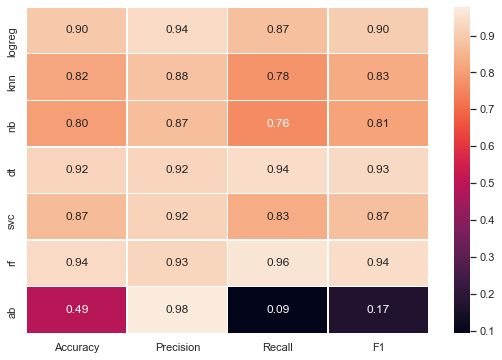

In [68]:
sns.set_theme()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df_ev.transpose(), annot=True, fmt=".2f", linewidths=.5, ax= ax)

# Testing

In [69]:
#from sklearn.datasets import load_iris
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import LinearSVC
#from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import make_pipeline
#from sklearn.ensemble import StackingClassifier
#
#
#
#X, y = load_iris(return_X_y=True)
#estimators = [
#    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
#    ('svr', make_pipeline(StandardScaler(),LinearSVC(random_state=42)))
#    ]
#
#clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
#
#from sklearn.model_selection import train_test_split
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
#clf.fit(X_train, y_train).score(X_test, y_test)
